In [4]:
import pandas as pd
import json

with open(".\internetspeed.json") as f:
  data = json.load(f)

df = pd.json_normalize(data)

#timestamp is in UTC timezone
df.index=pd.to_datetime(df['timestamp'])
df.head()

print("Min download.bandwidth, Mbps")
print(df['download.bandwidth'].min()*8/1000000)

print("Max download.bandwidth, Mbps")
print(df['download.bandwidth'].max()*8/1000000)

print("Min upload.bandwidth, Mbps")
print(df['upload.bandwidth'].min()*8/1000000)

print("Max upload.bandwidth, Mbps")
print(df['upload.bandwidth'].max()*8/1000000)

Min download.bandwidth, Mbps
53.636176
Max download.bandwidth, Mbps
94.721352
Min upload.bandwidth, Mbps
92.600064
Max upload.bandwidth, Mbps
106.45112


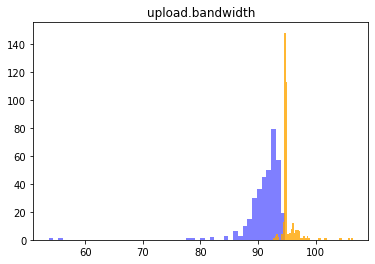

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

num_bins = 50
plt.hist(df['download.bandwidth']*8/1000000, num_bins, facecolor='blue', alpha=0.5)
plt.title("download.bandwidth")
plt.hist(df['upload.bandwidth']*8/1000000, num_bins, facecolor='orange', alpha=0.8)
plt.title("upload.bandwidth")
plt.show()



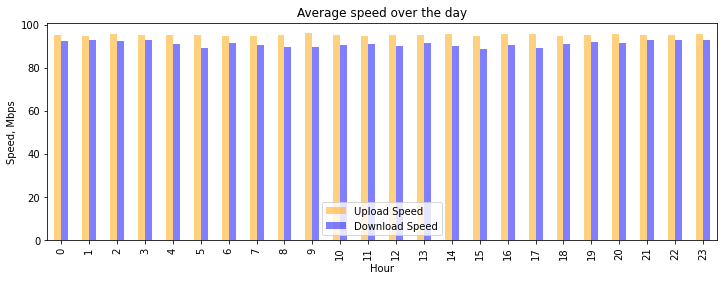

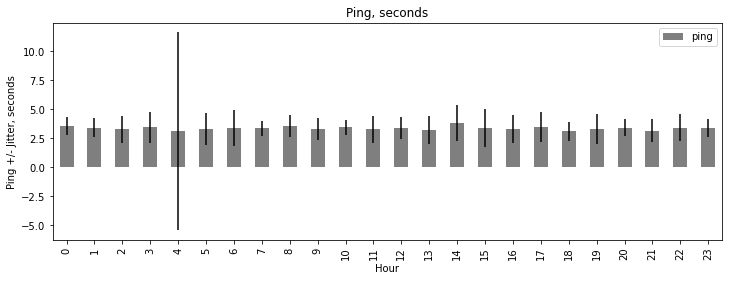

In [24]:
plotting = pd.DataFrame()
plotting['Download Speed'] =  df.groupby(df.index.hour)['download.bandwidth'].agg('mean')*8/1000000
plotting['Upload Speed'] = df.groupby(df.index.hour)['upload.bandwidth'].agg('mean')*8/1000000
plotting['dstd'] = df.groupby(df.index.hour)['download.bandwidth'].agg('std')*8/1000000
plotting['ustd'] = df.groupby(df.index.hour)['upload.bandwidth'].agg('std')*8/1000000
plotting['ping'] = df.groupby(df.index.hour)['ping.latency'].agg('mean')
plotting['jitter'] =  df.groupby(df.index.hour)['ping.jitter'].agg('mean')

plotting.head()

import numpy as np

plotting.plot(y=['Upload Speed', 'Download Speed'], kind="bar", alpha=0.5, color=["orange", "blue"],xticks=np.arange(24), title="Average speed over the day",ylabel="Speed, Mbps", xlabel="Hour", figsize=(12,4))
plotting.plot(y=['ping'], kind="bar", yerr="jitter", alpha=0.5, color=["black"],xticks=np.arange(24), title="Ping, seconds",ylabel="Ping +/- Jitter, seconds", xlabel='Hour', figsize=(12,4))
plt.show()